In [99]:
from plotly import express as px
from plotly import graph_objects as go
import pandas as pd
from geopy.distance import geodesic as GD
import matplotlib.pyplot as plt
import matplotlib.colors as mc
import matplotlib.cm as cmx
import numpy as np

In [162]:
flights = pd.read_csv('data/202112.csv', sep=';')
airports = pd.read_csv('data/airports.csv')

flights = flights.merge(airports[['Código OACI', 'LATGEOPOINT', 'LONGEOPOINT']], left_on='ICAO Aerodromo Origem', right_on='Código OACI').rename(columns={'LATGEOPOINT': 'lat_origem', 'LONGEOPOINT': 'lon_origem'})
flights = flights.merge(airports[['Código OACI', 'LATGEOPOINT', 'LONGEOPOINT']], left_on='ICAO Aerodromo Destino', right_on='Código OACI').rename(columns={'LATGEOPOINT': 'lat_destino', 'LONGEOPOINT': 'lon_destino'})
flights = flights.loc[flights['Situacao Voo'] == 'REALIZADO']
flights = flights.sort_values(by='Partida Real')
flights = flights.reset_index().rename(columns={'index': 'flight_index'})
flights['Partida Real'] = pd.to_datetime(flights['Partida Real'])
flights['origem'] = flights.apply(lambda row: [row['lat_origem'], row['lon_origem']], axis=1)
flights['destino'] = flights.apply(lambda row: [row['lat_destino'], row['lon_destino']], axis=1)
flights['dist'] = flights.apply(lambda row: GD(row['origem'], row['destino']).meters, axis=1)

C:\Users\alexia.pimentel\AppData\Local\Temp\ipykernel_27252\2418034677.py:1: DtypeWarning:

Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.



AttributeError: 'DatetimeIndex' object has no attribute 'apply'

In [182]:
hourly_flights = flights.set_index('Partida Real').resample('60t').apply(list).reset_index()
hourly_flights['numero_de_voos'] = hourly_flights['flight_index'].apply(len)
hourly_flights['data_partida'] = hourly_flights['Partida Real'].apply(lambda x: x.date()) 
hourly_flights = hourly_flights.loc[hourly_flights['numero_de_voos'] > 0]
hourly_flights['tot_dist'] = hourly_flights['dist'].apply(sum)

In [169]:
hourly_flights['data_partida'].iloc[0]

datetime.date(2021, 1, 12)

In [183]:
hourly_flights.to_csv('data/hourly_flights.csv')

In [137]:
h = pd.read_csv('data/hourly_flights.csv')

In [155]:
h['lat_origem'] = h['lat_origem'].apply(lambda x: ast.literal_eval(x))

In [158]:
h['lat_destino'] = h['lat_destino'].apply(lambda x: ast.literal_eval(x))

In [160]:
h['data_partida']

0      [datetime.date(2021, 1, 12), datetime.date(202...
1      [datetime.date(2021, 1, 12), datetime.date(202...
2      [datetime.date(2021, 1, 12), datetime.date(202...
3      [datetime.date(2021, 1, 12), datetime.date(202...
4      [datetime.date(2021, 1, 12), datetime.date(202...
                             ...                        
739    [datetime.date(2021, 12, 31), datetime.date(20...
740    [datetime.date(2021, 12, 31), datetime.date(20...
741    [datetime.date(2021, 12, 31), datetime.date(20...
742    [datetime.date(2021, 12, 31), datetime.date(20...
743    [datetime.date(2021, 12, 31), datetime.date(20...
Name: data_partida, Length: 744, dtype: object

In [159]:
h['data_partida'] = h['data_partida'].apply(lambda x: ast.literal_eval(x))

ValueError: malformed node or string on line 1: <ast.Call object at 0x000001CF05A17790>

In [152]:
h.columns

Index(['Partida Real', 'flight_index', 'ICAO Empresa Aerea', 'Numero Voo',
       'Codigo DI', 'Codigo Tipo Linha', 'ICAO Aerodromo Origem',
       'ICAO Aerodromo Destino', 'Partida Prevista', 'Chegada Prevista',
       'Chegada Real', 'Situacao Voo', 'Código OACI_x', 'lat_origem',
       'lon_origem', 'Código OACI_y', 'lat_destino', 'lon_destino',
       'data_partida', 'origem', 'destino', 'dist', 'numero_de_voos'],
      dtype='object')

In [146]:
import ast

In [153]:
idx = ast.literal_eval(h['lat_origem'][0])

In [149]:
len(idx)

11

In [179]:
colorscales = [plt.cm.hot, plt.cm.viridis, plt.cm.inferno_r, plt.cm.viridis_r]
import random

In [184]:
plt.cm.hot.name

'hot'

In [181]:
hourly_flights['dist'].apply(sum)

0       8.789704e+06
1       7.050183e+06
2       4.639564e+07
3       6.543017e+07
4       7.010031e+07
            ...     
8491    6.043178e+07
8492    4.601153e+07
8493    4.334799e+07
8494    2.686403e+07
8495    2.357955e+07
Name: dist, Length: 744, dtype: float64

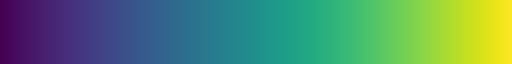

In [180]:
random.choice(colorscales)

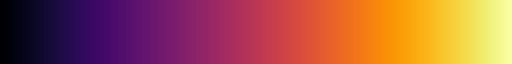

In [171]:
colorscales = [plt.cm.inferno, plt.cm.viridis, plt.cm.inferno_r, plt.cm.viridis_r]
current_scale = random.choice(colorscales)

In [98]:
fig = go.Figure()
fig.update_layout(geo=dict(scope='south america', fitbounds='locations', center=dict(lat=-13.0, lon=-53.2), showland=False, showocean=False, showcoastlines=False, showcountries=False, bgcolor='rgb(29,29,29)'))
fig.update_layout(paper_bgcolor = 'rgb(29, 29, 29)', plot_bgcolor = 'rgb(29, 29, 29)')

cmap = plt.cm.inferno
norm = mc.Normalize(flights['dist'].min(), flights['dist'].max())
color = cmx.ScalarMappable(cmap = cmap, norm=norm).to_rgba(flights['dist'], bytes=True)
color = ['rgba(' + str(x[0]) + ', ' + str(x[1]) + ', ' + str(x[2]) + ', ' + str(x[3]) + ')' for x in color]

for index, flight in flights.loc[flights.data_partida == flights.data_partida.min()].iterrows():
    lat = [flight['lat_origem'], flight['lat_destino']]
    lon = [flight['lon_origem'], flight['lon_destino']]
    fig.add_trace(go.Scattergeo(lon=lon, lat=lat, mode='lines', fillcolor='black', opacity=0.3, line=dict(width=0.2), marker=dict(color=color[index], opacity=0.1)))

fig.update_xaxes(showticklabels=False, showgrid=False, zeroline=False, visible=False)
fig.update_yaxes(showticklabels=False, showgrid=False, zeroline=False, visible=False)
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.update_layout(height=800, width=800, template="plotly_dark", showlegend=False)
fig.show()